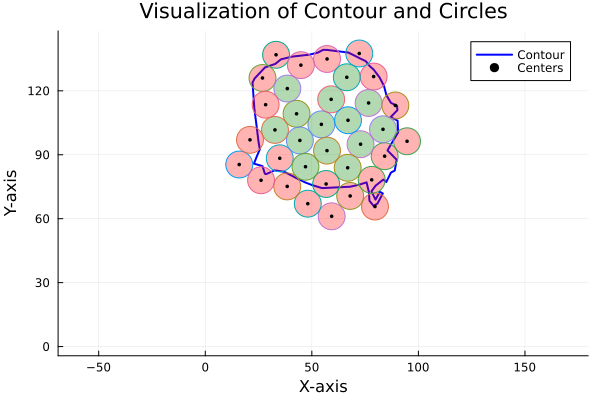

In [4]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=1)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min

    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio

    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position

    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false

            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end

            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end

            attempts += 1
        end

        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle after $max_attempts attempts")
        end
    end

    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0
    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            if distance > 0
                circle_energy += distance^2
            else
                circle_energy += repulsion_penalty
            end
        end
    end

    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_strength = 1e6  # Strength of repulsion from the contour

    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center

        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if circle_in_polygon(circle, smooth_x, smooth_y) # Circle is touching or outside the boundary
                repell_energy += 1 / distance_to_boundary 
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 2 * center_energy + 1 * repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        if circle_in_polygon(circle, smooth_x, smooth_y)
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
        else
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end

# Function to optimize the position of a single circle
function minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    function objective(params)
        updated_circles = deepcopy(circles)
        updated_circles[circle_index] = Circle(params[1], params[2], circles[circle_index].radius, circles[circle_index].label)
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    initial_params = [circles[circle_index].x_coord, circles[circle_index].y_coord]
    result = optimize(objective, initial_params, SimulatedAnnealing())
    optimized_params = Optim.minimizer(result)
    circles[circle_index] = Circle(optimized_params[1], optimized_params[2], circles[circle_index].radius, circles[circle_index].label)
end

# Function to iteratively optimize energy for random circles
function iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
    for _ in 1:num_iterations
        circle_index = rand(1:length(circles))
        minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    end
    return circles
end

# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 35
num_iterations = 8*num_circles
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
optimized_circles = iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)

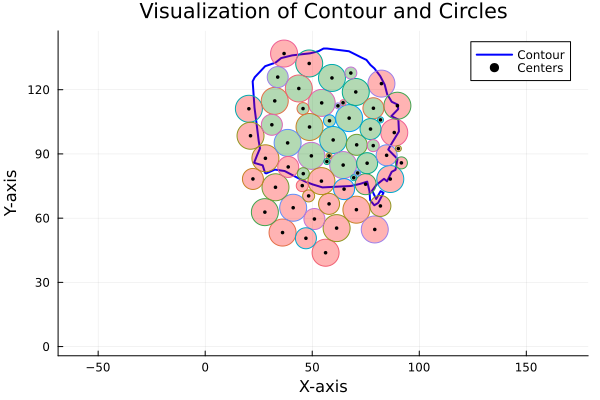

LoadError: MethodError: objects of type Vector{Float64} are not callable
Use square brackets [] for indexing an Array.

In [1]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, QuadGK

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=1)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min

    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio

    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground with varied radii
function make_circles(num_circles; x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position

    # Determine the counts for each radius
    count_6_3 = round(Int, 0.5 * num_circles)  # 50% with radius 6.3
    count_4_9 = round(Int, 0.25 * num_circles)  # 50% with radius 4.9
    count_2_8 = round(Int, 0.125 * num_circles)  # 25% with radius 2.8
    count_1_4 = round(Int, 0.125 * num_circles)  # 25% with radius 1.4

    # Ensure the total is equal to num_circles
    total_assigned = count_6_3 + count_4_9 + count_2_8 + count_1_4
    if total_assigned != num_circles
        count_6_3 += num_circles - total_assigned  # Adjust to match total count
    end

    # Define radii and their respective counts
    radii_counts = [(6.3, count_6_3), (4.9, count_4_9), (2.8, count_2_8), (1.4, count_1_4)]

    id = 1  # Start ID counter
    for (radius, count) in radii_counts
        for _ in 1:count
            attempts = 0
            while attempts < max_attempts
                x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
                y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
                overlap = false

                # Check if this circle overlaps with any existing circles
                for circle in circles
                    if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                        overlap = true
                        break
                    end
                end

                if !overlap
                    # Store the circle with its properties
                    push!(circles, Circle(x, y, radius, id))
                    id += 1  # Increment ID for each circle
                    break
                end

                attempts += 1
            end

            # If no non-overlapping position found after max attempts, skip this circle
            if attempts == max_attempts
                println("Failed to place circle after $max_attempts attempts")
            end
        end
    end

    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0
    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            if distance > 0
                circle_energy += distance^2
            else
                circle_energy += repulsion_penalty
            end
        end
    end

    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_strength = 1e6  # Strength of repulsion from the contour

    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center

        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if circle_in_polygon(circle, smooth_x, smooth_y) # Circle is touching or outside the boundary
                repell_energy += abs(1 / distance_to_boundary) 
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 5 * center_energy + 1 * repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        if circle_in_polygon(circle, smooth_x, smooth_y)
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
        else
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end

# Function to optimize the position of a single circle
function minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    function objective(params)
        updated_circles = deepcopy(circles)
        updated_circles[circle_index] = Circle(params[1], params[2], circles[circle_index].radius, circles[circle_index].label)
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    initial_params = [circles[circle_index].x_coord, circles[circle_index].y_coord]
    result = optimize(objective, initial_params, SimulatedAnnealing())
    optimized_params = Optim.minimizer(result)
    circles[circle_index] = Circle(optimized_params[1], optimized_params[2], circles[circle_index].radius, circles[circle_index].label)
end

# Function to iteratively optimize energy for random circles
function iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
    for _ in 1:num_iterations
        circle_index = rand(1:length(circles))
        minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    end
    return circles
end

# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 60
num_iterations = 6*num_circles
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
optimized_circles = iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)


# Calculate centroid
centroid_x = mean(x)
centroid_y = mean(y)

# Calculate angles and distances for each point relative to centroid
θ = atan.(y .- centroid_y, x .- centroid_x)
r = sqrt.((x .- centroid_x).^2 + (y .- centroid_y).^2)


arclength = [0.0]
for i in 2:length(x)
    push!(arclength, arclength[end] + sqrt((x[i] - x[i-1])^2 + (y[i] - y[i-1])^2))
end

# Normalize arclength to [0, 2π]
total_arclength = arclength[end]
t = (arclength ./ total_arclength) .* 2π
t = t .+ range(0, stop=1e-6, length=length(t))  # Add small perturbation

# Create the splines using arclength as parameter
spline_x = Spline1D(t, x; k=3, periodic=true)  # Using arclength for parameterization
spline_y = Spline1D(t, y; k=3, periodic=true)  # Using arclength for parameterization

# Define the integrand function for Green's theorem
# f(t) = x(t)dy/dt - y(t)dx/dt
function integrand(t)
    x = spline_x(t)
    y = spline_y(t)
    dxdt = derivative(spline_x, t)
    dydt = derivative(spline_y, t)
    return x * dydt - y * dxdt
end

# Calculate area using QuadGK
# Area = 1/2 ∮ (x dy - y dx) = 1/2 ∫ (x dy/dt - y dx/dt) dt
area= quadgk(integrand, 0, 2π)  # Assuming parameterization is over [0, 2π]
area = abs(area[1]) * 0.5

function circle_contour_intersection_area(circle, spline_x, spline_y, t_fine)
    # Circle parameters
    cx = circle.x_coord
    cy = circle.y_coord
    r = circle.radius

    # If circle is fully inside, return its full area
    if circle_in_polygon(circle, smooth_x, smooth_y)
        return π * r^2
    end

    # Create derivative splines
    dx_spline = Spline1D(t_fine, [spline_x(t) for t in t_fine]; k=3, periodic=true)
    dy_spline = Spline1D(t_fine, [spline_y(t) for t in t_fine]; k=3, periodic=true)

    # Function to check if a point is inside the circle
    function is_point_in_circle(x, y)
        return (x - cx)^2 + (y - cy)^2 <= r^2
    end

    # Integrand for Green's theorem
    function integrand(t)
        x = spline_x(t)
        y = spline_y(t)
        dx = derivative(dx_spline, t)
        dy = derivative(dy_spline, t)

        if is_point_in_circle(x, y)
            return x * dy[1] - y * dx[1]  # Take first element of derivative array
        else
            return 0.0
        end
    end

    # Integrate over the full parameter range
    area, _ = quadgk(integrand, 0, 2π, rtol=1e-8)

    # Take absolute value and divide by 2 as per Green's theorem
    intersection_area = abs(area) / 2

    # The result cannot be larger than the circle's area
    return min(intersection_area, π * r^2)
end


function compute_circle_coverage(circles, spline_x, spline_y, t_fine, total_area)
    total_covered_area = 0.0

    for (i, circle) in enumerate(circles)
        partial_area = circle_contour_intersection_area(circle, spline_x, spline_y, t_fine)
        total_covered_area += partial_area
    end

    println("Total covered area: $total_covered_area")
    println("Container area: $total_area")

    coverage = total_covered_area / total_area
    return coverage
end

t_fine = range(0, 2π, length=200)
coverage = compute_circle_coverage(optimized_circles, smooth_x, smooth_y, t_fine, area)
println("Circle coverage within the container: ", coverage)

     

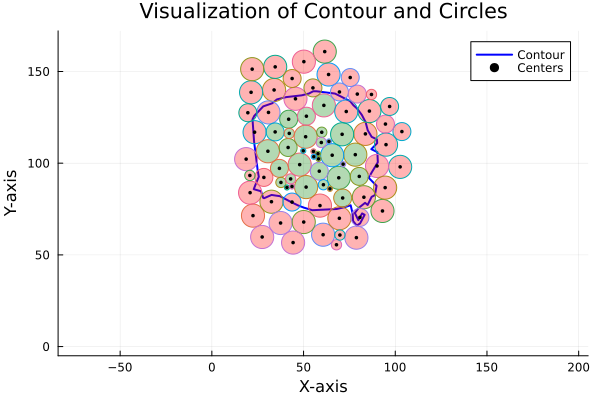

LoadError: MethodError: objects of type Vector{Float64} are not callable
Use square brackets [] for indexing an Array.

In [7]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, QuadGK

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=1)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min

    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio

    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground with varied radii
function make_circles(num_circles; x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position

    # Determine the counts for each radius
    count_6_3 = round(Int, 0.5 * num_circles)  # 50% with radius 6.3
    count_4_9 = round(Int, 0.25 * num_circles)  # 50% with radius 4.9
    count_2_8 = round(Int, 0.125 * num_circles)  # 25% with radius 2.8
    count_1_4 = round(Int, 0.125 * num_circles)  # 25% with radius 1.4

    # Ensure the total is equal to num_circles
    total_assigned = count_6_3 + count_4_9 + count_2_8 + count_1_4
    if total_assigned != num_circles
        count_6_3 += num_circles - total_assigned  # Adjust to match total count
    end

    # Define radii and their respective counts
    radii_counts = [(6.3, count_6_3), (4.9, count_4_9), (2.8, count_2_8), (1.4, count_1_4)]

    id = 1  # Start ID counter
    for (radius, count) in radii_counts
        for _ in 1:count
            attempts = 0
            while attempts < max_attempts
                x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
                y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
                overlap = false

                # Check if this circle overlaps with any existing circles
                for circle in circles
                    if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                        overlap = true
                        break
                    end
                end

                if !overlap
                    # Store the circle with its properties
                    push!(circles, Circle(x, y, radius, id))
                    id += 1  # Increment ID for each circle
                    break
                end

                attempts += 1
            end

            # If no non-overlapping position found after max attempts, skip this circle
            if attempts == max_attempts
                println("Failed to place circle after $max_attempts attempts")
            end
        end
    end

    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0
    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            if distance > 0
                circle_energy += distance^2
            else
                circle_energy += repulsion_penalty
            end
        end
    end

    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_strength = 1e6  # Strength of repulsion from the contour

    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        if circle_in_polygon(circle, smooth_x, smooth_y) 
            center_energy += distance_to_center  # Attraction force to the center
        else
            center_energy += 100*distance_to_center
        end
    end

    # Total energy
    total_energy = circle_energy + center_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        if circle_in_polygon(circle, smooth_x, smooth_y)
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
        else
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end

# Function to optimize the position of a single circle
function minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    function objective(params)
        updated_circles = deepcopy(circles)
        updated_circles[circle_index] = Circle(params[1], params[2], circles[circle_index].radius, circles[circle_index].label)
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    initial_params = [circles[circle_index].x_coord, circles[circle_index].y_coord]
    result = optimize(objective, initial_params, SimulatedAnnealing())
    optimized_params = Optim.minimizer(result)
    circles[circle_index] = Circle(optimized_params[1], optimized_params[2], circles[circle_index].radius, circles[circle_index].label)
end

# Function to iteratively optimize energy for random circles
function iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
    for _ in 1:num_iterations
        circle_index = rand(1:length(circles))
        minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    end
    return circles
end

# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 80
num_iterations = 8*num_circles
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
optimized_circles = iterative_optimization(circles, smooth_x, smooth_y, num_iterations)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)


# Calculate centroid
centroid_x = mean(x)
centroid_y = mean(y)

# Calculate angles and distances for each point relative to centroid
θ = atan.(y .- centroid_y, x .- centroid_x)
r = sqrt.((x .- centroid_x).^2 + (y .- centroid_y).^2)


arclength = [0.0]
for i in 2:length(x)
    push!(arclength, arclength[end] + sqrt((x[i] - x[i-1])^2 + (y[i] - y[i-1])^2))
end

# Normalize arclength to [0, 2π]
total_arclength = arclength[end]
t = (arclength ./ total_arclength) .* 2π
t = t .+ range(0, stop=1e-6, length=length(t))  # Add small perturbation

# Create the splines using arclength as parameter
spline_x = Spline1D(t, x; k=3, periodic=true)  # Using arclength for parameterization
spline_y = Spline1D(t, y; k=3, periodic=true)  # Using arclength for parameterization

# Define the integrand function for Green's theorem
# f(t) = x(t)dy/dt - y(t)dx/dt
function integrand(t)
    x = spline_x(t)
    y = spline_y(t)
    dxdt = derivative(spline_x, t)
    dydt = derivative(spline_y, t)
    return x * dydt - y * dxdt
end

# Calculate area using QuadGK
# Area = 1/2 ∮ (x dy - y dx) = 1/2 ∫ (x dy/dt - y dx/dt) dt
area= quadgk(integrand, 0, 2π)  # Assuming parameterization is over [0, 2π]
area = abs(area[1]) * 0.5

function circle_contour_intersection_area(circle, spline_x, spline_y, t_fine)
    # Circle parameters
    cx = circle.x_coord
    cy = circle.y_coord
    r = circle.radius

    # If circle is fully inside, return its full area
    if circle_in_polygon(circle, smooth_x, smooth_y)
        return π * r^2
    end

    # Create derivative splines
    dx_spline = Spline1D(t_fine, [spline_x(t) for t in t_fine]; k=3, periodic=true)
    dy_spline = Spline1D(t_fine, [spline_y(t) for t in t_fine]; k=3, periodic=true)

    # Function to check if a point is inside the circle
    function is_point_in_circle(x, y)
        return (x - cx)^2 + (y - cy)^2 <= r^2
    end

    # Integrand for Green's theorem
    function integrand(t)
        x = spline_x(t)
        y = spline_y(t)
        dx = derivative(dx_spline, t)
        dy = derivative(dy_spline, t)

        if is_point_in_circle(x, y)
            return x * dy[1] - y * dx[1]  # Take first element of derivative array
        else
            return 0.0
        end
    end

    # Integrate over the full parameter range
    area, _ = quadgk(integrand, 0, 2π, rtol=1e-8)

    # Take absolute value and divide by 2 as per Green's theorem
    intersection_area = abs(area) / 2

    # The result cannot be larger than the circle's area
    return min(intersection_area, π * r^2)
end


function compute_circle_coverage(circles, spline_x, spline_y, t_fine, total_area)
    total_covered_area = 0.0

    for (i, circle) in enumerate(circles)
        partial_area = circle_contour_intersection_area(circle, spline_x, spline_y, t_fine)
        total_covered_area += partial_area
    end

    println("Total covered area: $total_covered_area")
    println("Container area: $total_area")

    coverage = total_covered_area / total_area
    return coverage
end

t_fine = range(0, 2π, length=200)
coverage = compute_circle_coverage(optimized_circles, smooth_x, smooth_y, t_fine, area)
println("Circle coverage within the container: ", coverage)

     